In [57]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import timeit
import mplcyberpunk
from matplotlib.pyplot import Line2D
from scipy.stats.sampling import NumericalInverseHermite, NumericalInversePolynomial
from scipy.stats import norm
from pathlib import Path
import logging
import sys
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)
ROOT_DIR = Path('/Users/palmerio/Code_projects/astropalmerio/dev/')

In [2]:
def where_value(value, array):
    """
        Function that returns the indice of a value in a !!! sorted !!! array.
        Essentially a dichotomy (bisection in english).
        It returns indice for which:
        array[indice] < value <= array[indice+1]
        Returns -1 if value is out of bounds.

        Parameters:
        ------------
        value : [float]
            Value to find in the array.

        array : [array]
            Array in which to look.

        Returns:
        ---------
        indice : [int]
            The indice where the value was found in the array.
    """
    imin = 0
    imax = len(array)-1
    if(value < array[0] or value > array[-1]):
        print("[Warning] in where_value : value is out of range of the array, indice returned : -1")
        indice = -1
    else:
        jj = 0
        while True:
            if (jj > 100000):
                print("[Error] in where_value : looping over 100000 times, aborting.")
                print("[Error] in where_value : imax, imin, j = ", imax, imin, j)
                break
            j = int((imin + imax)/2)
            jj += 1
            if(value > array[j]):
                imin = j+1
            elif(value < array[j-1]):
                imax = j
            else:
                break
        indice = j-1

    return indice

In [94]:
def anpdf(x, mu, s1, s2):
    """
    Asymmetric normal probability density function.
    In the form :   { exp( -0.5*(x-mu)**2 / s1**2)     if x < mu
                    { exp( -0.5*(x-mu)**2 / s2**2)     if x >= mu

    Parameters
    ----------
    x : int, float, or array-like
        Value(s) at which to evaluate the PDF
    mu : int, float
        Location parameter (mean) of the asymmetric normal distribution.
    s1 : int, float
        Scale parameter at x < mu
    s2 : int, optional
        Scale parameter at x >= mu

    Returns
    -------
    pdf : int, float or array-like
        The PDF evaluated at x.
    """
    if (s1 == 0) and (s2 == 0):
        raise ValueError("Sigma 1 and Sigma 2 cannot be equal to zero at the same time.")
    elif (s1 < 0) or (s2 < 0):
        raise ValueError("Sigma 1 and Sigma 2 must be positive.")

    a = 2. / (np.sqrt(2. * np.pi) * (s1 + s2))
    if isinstance(x, np.ndarray):
        pdf = np.where(x < mu,
                       np.exp(-0.5*(x - mu)**2 / s1**2),
                       np.exp(-0.5*(x - mu)**2 / s2**2))
    else:
        if x < mu:
            pdf = np.exp(-0.5*(x - mu)**2 / s1**2)
        else:
            pdf = np.exp(-0.5*(x - mu)**2 / s2**2)
    # Control for case where s2=0, which will return NaN at x=mu
    if s2 == 0:
        pdf[np.isnan(pdf)] = 1
    return a * pdf


def ancdf(x, mu, s1, s2):
    """
    Asymmetric normal cumulative distribution function for a pdf of the
    form :   { exp( -0.5*(x-mu)**2 / s1**2)     if x < mu
             { exp( -0.5*(x-mu)**2 / s2**2)     if x >= mu

    Parameters
    ----------
    x : int, float, or array-like
        Value(s) at which to evaluate the PDF
    mu : int, float
        Location parameter (mean) of the asymmetric normal distribution.
    s1 : int, float
        Scale parameter at x < mu
    s2 : int, optional
        Scale parameter at x >= mu

    Returns
    -------
    pdf : int, float or array-like
        The CDF evaluated at x.
    """

    if (s1 == 0) and (s2 == 0):
        raise ValueError("Sigma 1 and Sigma 2 cannot be equal to zero at the same time.")
    elif (s1 < 0) or (s2 < 0):
        raise ValueError("Sigma 1 and Sigma 2 must be positive.")

    a = 2. / (s1 + s2)
    if isinstance(x, np.ndarray):
        cdf = np.where(x < mu,
                       s1 * norm.cdf(x, mu, s1),
                       0.5*(s1 - s2) + s2*norm.cdf(x, mu, s2))
    else:
        if x < mu:
            cdf = s1 * norm.cdf(x, mu, s1)
        else:
            cdf = (0.5*(s1 - s2) + s2*norm.cdf(x, mu, s2))
    return a*cdf

class AsymNormal():
    def __init__(self, mu, s1, s2):
        self.mu = mu
        self.s1 = s1
        self.s2 = s2

    def pdf(self, x):
        norm = 2. / (np.sqrt(2. * np.pi) * (self.s1 + self.s2))
        if isinstance(x, np.ndarray):
            pdf = np.exp(- 0.5 * (x - self.mu) ** 2 / self.s1 ** 2)
            w = np.where(x > self.mu)
            pdf[w] = np.exp(- 0.5 * (x[w] - self.mu) ** 2 / self.s2 ** 2)
        else:
            if x < self.mu:
                pdf = np.exp(- 0.5 * (x - self.mu) ** 2 / self.s1 ** 2)
            else:
                pdf = np.exp(- 0.5 * (x - self.mu) ** 2 / self.s2 ** 2)
        return norm*pdf

    def cdf(self, x):
        norm = 2. / (self.s1 + self.s2)
        if isinstance(x, np.ndarray):
            cdf = self.s1 * stats.norm.cdf(x, self.mu, self.s1)
            w = np.where(x > self.mu)
            cdf[w] = (0.5 * (self.s1 - self.s2) + self.s2 * stats.norm.cdf(x[w], self.mu, self.s2))
        else:
            if x < self.mu:
                cdf = self.s1 * stats.norm.cdf(x, self.mu, self.s1)
            else:
                cdf = (0.5 * (self.s1 - self.s2) + self.s2 * stats.norm.cdf(x, self.mu, self.s2))

        return norm*cdf

In [95]:
def get_corresponding_y_value(x_val, x, y):
    """
        Find the y value for a given x value for a pair of finite (x,y) arrays.
        If the x value is not in the x array, a linear interpolation is assumed.
    """

    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape.")
    if isinstance(x_val, np.ndarray):
        invalid_values = any(x_val < np.min(x)) or any(x_val > np.max(x))
    elif isinstance(x_val, (float,int)):
        invalid_values = (x_val < np.min(x)) or (x_val > np.max(x))
    if invalid_values:
        raise ValueError("Values searched must be within bounds of the array, cannot extrapolate.")
    
    y_step = y[1:]-y[:-1]
    i = x.searchsorted(x_val, side='left')
    # if x values are in x, return corresponding y values
    # otherwise, linearly interpolate between the bounding values
    # Beware of special case if index of x value is 0
    # to avoid unwanted behavior
    y_val = np.where(i == 0,
                     y[i],
                     y[i-1] + y_step[i-1]*(x_val-x[i-1])/(x[i]-x[i-1]))
    return y_val

def sample_from_CDF(x, Fx, nb_draws, val_min=None, val_max=None):
    """
    """

    rand_min = np.min(Fx)
    rand_max = np.max(Fx)

    # Check for min bound
    if val_min is not None:
        if val_min > np.max(x):
            raise ValueError("The minimum allowed value is greater than the maximum value of the provided domain.")
        else:
            rand_min = get_corresponding_y_value(val_min, x, Fx)

    # Check for max bound
    if val_max is not None:
        if val_max < np.min(x):
            raise ValueError("The maximum allowed value is greater than the minimum value of the provided domain.")
        else:
            rand_max = get_corresponding_y_value(val_max, x, Fx)

    rand = (rand_max-rand_min) * np.random.rand(nb_draws) + rand_min
    drawings = get_corresponding_y_value(rand, Fx, x)

    return drawings


In [96]:
mu = 10
sigma1 = 3
sigma2 = 5
step = 1
urng = np.random.default_rng()

# limits
x_min = mu - 5.*sigma1
x_max = mu + 5.*sigma2

# create Cumulative distribution
x = np.concatenate((np.arange(x_min, mu, step),
                   np.arange(mu, x_max, 5*step)))
# x = np.zeros(10)
# for i in range(len(x)):
#     x[i] = x[i-1] + 0.25*i*2
# x = np.logspace(-1, 1.5, 10)
# x = np.array([-20,-10,-5,0,1,2,3,4,5,10,20,30,50])

px = anpdf(x, mu, sigma1, sigma2)
Fx = ancdf(x, mu, sigma1, sigma2)
dist = AsymNormal(mu, sigma1, sigma2)

In [97]:
mu = 10
sigma1 = 1
sigma2 = 0
# limits
x_min = mu - 5.*sigma1
x_max = mu + 5.*sigma2
x = np.linspace(x_min, x_max, 10)

pdf = anpdf(x, mu, sigma1, sigma2)

/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_44635/2004992329.py:32: RuntimeWarning: divide by zero encountered in divide
  np.exp(-0.5*(x - mu)**2 / s2**2))
/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_44635/2004992329.py:32: RuntimeWarning: invalid value encountered in divide
  np.exp(-0.5*(x - mu)**2 / s2**2))


In [104]:
from astropalmerio.mc.utils import get_corresponding_y_value, log_to_lin, lin_to_log


ModuleNotFoundError: No module named 'astropalmerio'

/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_44635/2004992329.py:31: RuntimeWarning: divide by zero encountered in divide
  np.exp(-0.5*(x - mu)**2 / s1**2),


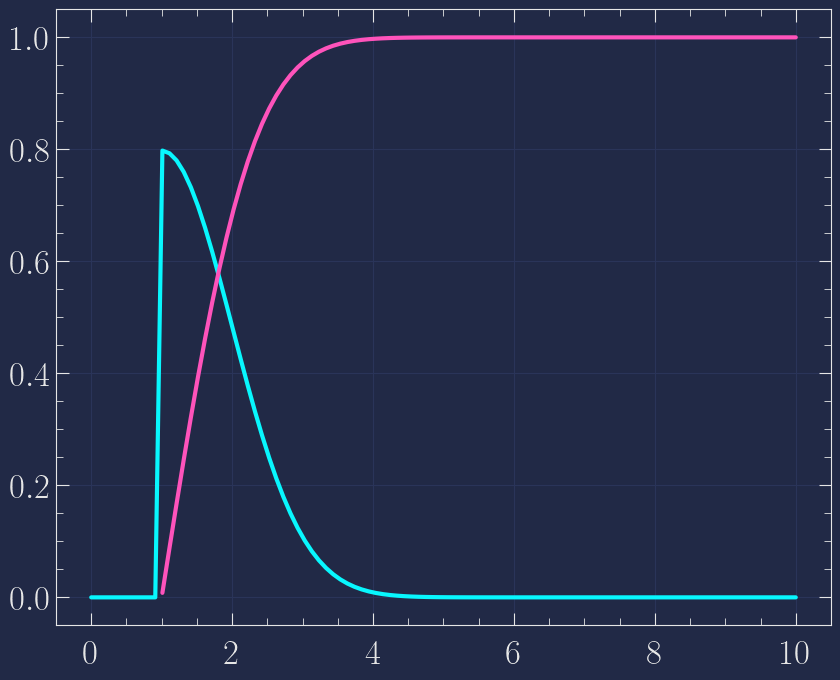

In [100]:
mu = 1
sigma1 = 0
sigma2 = 1
# limits
x_min = mu - 5.*sigma1
x_max = mu + 5.*sigma2
x = np.linspace(0, 10, 100)

plt.plot(x, anpdf(x, mu, sigma1, sigma2))
plt.plot(x, ancdf(x, mu, sigma1, sigma2))

In [64]:
x < mu

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

## Without any bounds, using entire domain

## Figure to illustrate CDF sampling

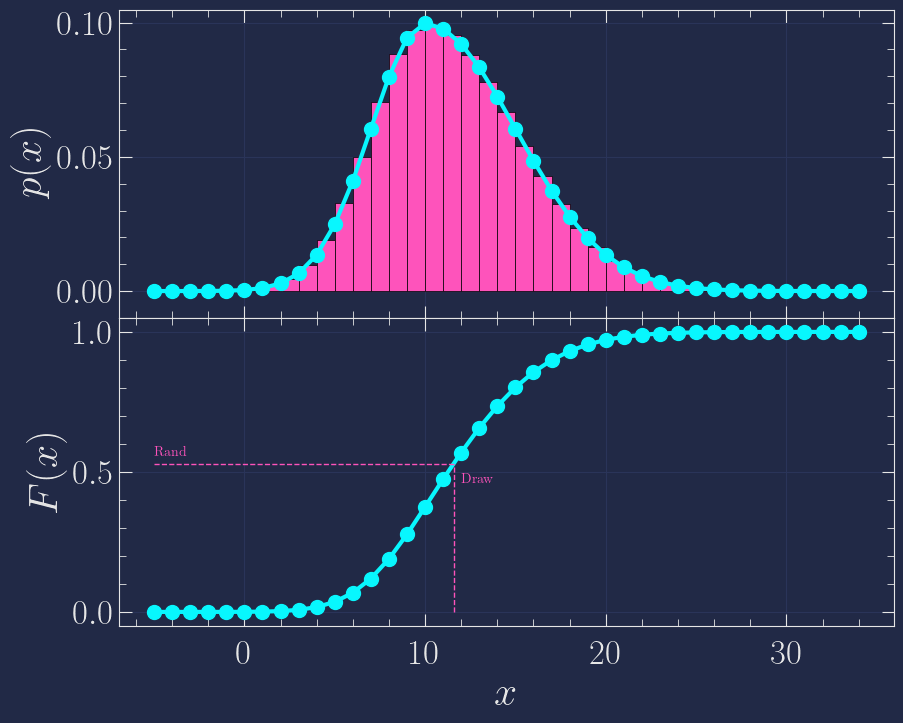

In [26]:
plt.style.use('mycyberpunk')

# Input data
mu = 10
sigma1 = 3
sigma2 = 5
step = 1

# limits
x_min = mu - 5.*sigma1
x_max = mu + 5.*sigma2

# create Cumulative distribution
x = np.arange(x_min, x_max, step)
px = anpdf(x, mu, sigma1, sigma2)
Fx = ancdf(x, mu, sigma1, sigma2)

# Sample from it
drawings = sample_from_CDF(x, Fx, nb_draws=int(1e6))
rand = 0.53
draw = get_corresponding_value(rand, Fx, x)

# Plot
fig, axes = plt.subplots(2, sharex=True)
ax1 = axes[0]
ax2 = axes[1]

# Show distributions
ax1.plot(x, px, marker='o', color='C0')
ax2.plot(x, Fx, marker='o', color='C0')
ax1.hist(drawings, density=True, color='C1', linewidth=0.5, bins=x)

# Add the random number and the corresponding drawing
ax2.add_artist(Line2D((x.min(), draw), (rand,rand), color='C1', ls='--', lw=1))
ax2.add_artist(Line2D((draw, draw), (0,rand), color='C1', ls='--', lw=1))
ax2.annotate('Rand', (x.min(), rand),
             xytext=(0,5),
             textcoords='offset points',
             color='C1')
ax2.annotate('Draw', (draw, rand),
             xytext=(5,-15),
             textcoords='offset points',
             color='C1')



ax1.set_ylabel(r'$p(x)$')
ax2.set_ylabel(r'$F(x)$')
ax2.set_xlabel(r'$x$')

# mplcyberpunk.add_glow_effects(ax1, gradient_fill=True)
# mplcyberpunk.make_lines_glow(ax1)
# mplcyberpunk.make_lines_glow(ax2)
ax1.set_ylim(ymin=-0.01)

fig.subplots_adjust(hspace=0)

fig.savefig(ROOT_DIR/'plots/CDF_sampling.png')
plt.show()

## Imposing a restricted domain

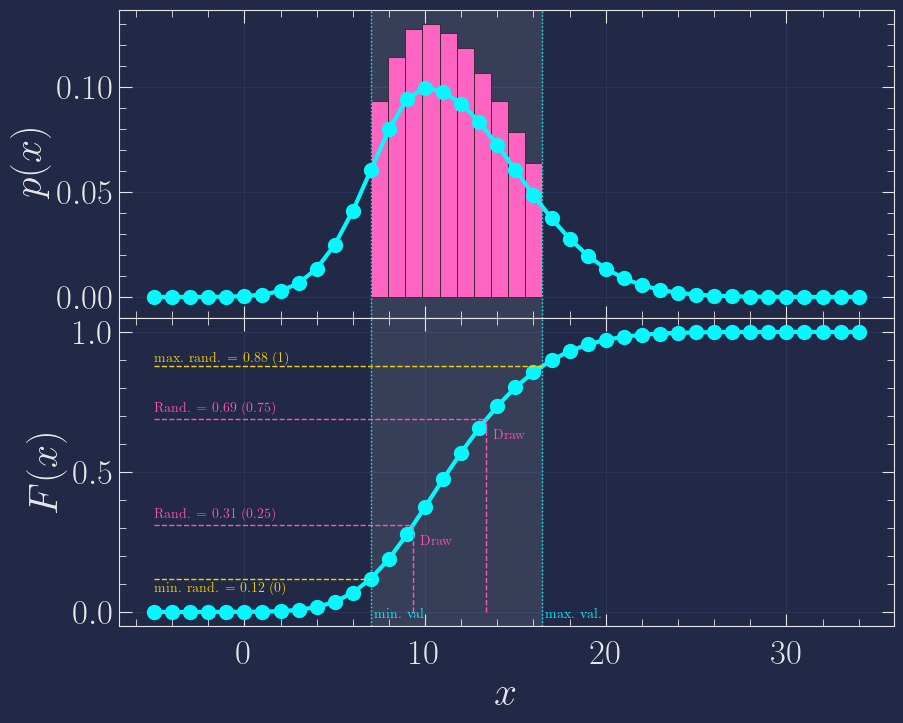

In [27]:
plt.style.use('mycyberpunk')

# Input data
mu = 10
sigma1 = 3
sigma2 = 5
step = 1
val_min = 7
val_max = 16.5

# limits
x_min = mu - 5.*sigma1
x_max = mu + 5.*sigma2

# create Cumulative distribution
x = np.arange(x_min, x_max, step)
px = anpdf(x, mu, sigma1, sigma2)
Fx = ancdf(x, mu, sigma1, sigma2)

# Sample from it
drawings = sample_from_CDF(x, Fx, nb_draws=int(1e6), val_min=val_min, val_max=val_max)
rand_min = get_corresponding_value(val_min, x, Fx)
rand_max = get_corresponding_value(val_max, x, Fx)
rand_uniform = 0.75
rand = (rand_max-rand_min) * rand_uniform + rand_min
draw = get_corresponding_value(rand, Fx, x)
rand_uniform2 = 0.25
rand2 = (rand_max-rand_min) * rand_uniform2 + rand_min
draw2 = get_corresponding_value(rand2, Fx, x)


# Plotting
fig, axes = plt.subplots(2, sharex=True)
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(x, px, marker='o', color='C0')
ax2.plot(x, Fx, marker='o', color='C0')
ax1.hist(drawings, density=True, color='C1', linewidth=0.5)

# Actual random number drawn and corresponding value
ax2.add_artist(Line2D((x.min(), draw), (rand,rand), color='C1', ls='--', lw=1))
ax2.add_artist(Line2D((draw, draw), (0,rand), color='C1', ls='--', lw=1))
ax2.annotate(f'Rand. = {rand:.2f} ({rand_uniform:.2f})', (x.min(), rand),
             xytext=(0,5),
             textcoords='offset points',
             color='C1')
ax2.annotate('Draw', (draw, rand),
             xytext=(5,-15),
             textcoords='offset points',
             color='C1')
# 2nd rand
ax2.add_artist(Line2D((x.min(), draw2), (rand2,rand2), color='C1', ls='--', lw=1))
ax2.add_artist(Line2D((draw2, draw2), (0,rand2), color='C1', ls='--', lw=1))
ax2.annotate(f'Rand. = {rand2:.2f} ({rand_uniform2:.2f})', (x.min(), rand2),
             xytext=(0,5),
             textcoords='offset points',
             color='C1')
ax2.annotate('Draw', (draw2, rand2),
             xytext=(5,-15),
             textcoords='offset points',
             color='C1')

# Min rand
ax2.add_artist(Line2D((x.min(), val_min), (rand_min,rand_min), color='C2', ls='--', lw=1))
ax2.annotate(f'min. rand. = {rand_min:.2f} (0)', (x.min(), rand_min),
             xytext=(0,-10),
             textcoords='offset points',
             color='C2')

# Max rand
ax2.add_artist(Line2D((x.min(), val_max), (rand_max,rand_max), color='C2', ls='--', lw=1))
ax2.annotate(f'max. rand. = {rand_max:.2f} (1)', (x.min(), rand_max),
             xytext=(0,3),
             textcoords='offset points',
             color='C2')

# Min val
ax1.axvline(val_min, color='C0', ls=':', lw=1)
ax2.axvline(val_min, color='C0', ls=':', lw=1)
ax2.annotate('min. val.', (val_min, 0), xytext=(2,-5), textcoords='offset points', color='C0')

# Max val
ax1.axvline(val_max, color='C0', ls=':', lw=1)
ax2.axvline(val_max, color='C0', ls=':', lw=1)
ax2.annotate('max. val.', (val_max, 0), xytext=(2,-5), textcoords='offset points', color='C0')

# Allowed area
ax1.axvspan(val_min, val_max, alpha=0.1, color='white')
ax2.axvspan(val_min, val_max, alpha=0.1, color='white')

ax1.set_ylabel(r'$p(x)$')
ax2.set_ylabel(r'$F(x)$')
ax2.set_xlabel(r'$x$')

# mplcyberpunk.add_glow_effects(ax1, gradient_fill=True)
# mplcyberpunk.make_lines_glow(ax1)
# mplcyberpunk.make_lines_glow(ax2)
ax1.set_ylim(ymin=-0.01)
fig.subplots_adjust(hspace=0)
fig.savefig(ROOT_DIR/'plots/CDF_sampling_w_bounds.png')

plt.show()

In [34]:
def meth1(x, p_x, F_x, nb_draws, val_min=None, val_max=None):
    step = x[1:]-x[:-1]
    if val_min is not None:
        # index must be at minimum 0
        ind_min = max(x.searchsorted(val_min)-1, 0)
        min_rand = F_x[ind_min]
    else:
        min_rand = 0
    if val_max is not None:
        max_rand = F_x[x.searchsorted(val_max)]
    else:
        max_rand = 1
    rand = (max_rand-min_rand) * np.random.rand(nb_draws) + min_rand
    # index must be at minimum 0
    ind_rand = max(F_x.searchsorted(rand)-1, 0)    
    draw = x[j-1] + step*(rand-F_x[j-1])/(F_x[j]-F_x[j-1])
    return draw

In [35]:
def meth2(x, p_x, F_x, nb_draws, val_min=None, val_max=None):
    step = (x_max - x_min) / float(precision)
    draw = np.zeros(nb_draws)
    for i in range(nb_draws):
        if val_min is not None:
            if val_max is not None:
                while (draw[i] <= val_min) or (draw[i] >= val_max):
                    t = np.random.random()
                    j = where_value(t, F_x)
                    draw[i] = x[j-1] + step*(t-F_x[j-1])/(F_x[j]-F_x[j-1])
            else:
                while (draw[i] <= val_min):
                    t = np.random.random()
                    j = where_value(t, F_x)
                    draw[i] = x[j-1] + step*(t-F_x[j-1])/(F_x[j]-F_x[j-1])
        else:
            if val_max is not None:
                while (draw[i] >= val_max):
                    t = np.random.random()
                    j = where_value(t, F_x)
                    draw[i] = x[j-1] + step*(t-F_x[j-1])/(F_x[j]-F_x[j-1])
            else:
                t = np.random.random()
                j = where_value(t, F_x)
                draw[i] = x[j-1] + step*(t-F_x[j-1])/(F_x[j]-F_x[j-1])
        if draw[i] == 0:
            draw[i] = 1e-100
    return draw

In [36]:
def meth3(x, dist, nb_draws, val_min=None, val_max=None):
    if val_min is None:
        val_min = -np.infty
    if val_max is None:
        val_max = np.infty
    rng = NumericalInversePolynomial(dist, mode=dist.mu, random_state=urng, domain=(val_min, val_max))
    rvs = rng.rvs(size=nb_draws)
    return rvs

# General conclusion : In all cases, method 2 is worse. Don't use it

## Comparison for 100 draws
For a small number of draws, the setup of the scipy function is actually quite slow

In [82]:
%timeit meth1(x, p_x, F_x, nb_draws=100)
%timeit meth2(x, p_x, F_x, nb_draws=100)
%timeit meth3(x, dist, nb_draws=100)

17.5 µs ± 978 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
362 µs ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
21.3 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Comparison for one million draws
For large number of draws, the scipy function becomes competitive

In [38]:
%timeit meth1(x, p_x, F_x, nb_draws=int(1e6))
%timeit meth2(x, p_x, F_x, nb_draws=int(1e6))
%timeit meth3(x, dist, nb_draws=int(1e6))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [39]:
%timeit meth1(x, px, Fx, nb_draws=int(1e6))
%timeit meth2(x, px, Fx, nb_draws=int(1e6))
%timeit meth3(x, dist, nb_draws=int(1e6))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [33]:
%timeit sample_from_CDF(x, Fx, nb_draws=int(1e6))
%timeit meth3(x, dist, nb_draws=int(1e6))

85.9 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.78 s ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Comparison for 100 draws, with bounds
Adding the presence of bounds makes the scipy function slightly faster

In [84]:
%timeit meth1(x, p_x, F_x, nb_draws=100, val_min=0, val_max=40)
%timeit meth2(x, p_x, F_x, nb_draws=100, val_min=0, val_max=40)
%timeit meth3(x, dist, nb_draws=100, val_min=0, val_max=40)

17.1 µs ± 509 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
393 µs ± 4.85 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
17.8 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Comparison for one million draws with bounds
For a large number of draws with bounds, the scipy function is actually better

In [85]:
%timeit meth1(x, p_x, F_x, nb_draws=int(1e6), val_min=0, val_max=40)
%timeit meth2(x, p_x, F_x, nb_draws=int(1e6), val_min=0, val_max=40)
%timeit meth3(x, dist, nb_draws=int(1e6), val_min=0, val_max=40)

64.4 ms ± 662 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.89 s ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
48.5 ms ± 4.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
np.random.seed(0)
x1 = meth1(x, p_x, F_x, nb_draws=int(1e6), val_min=None, val_max=None)
np.random.seed(0)
x2 = meth2(x, p_x, F_x, nb_draws=int(1e6), val_min=None, val_max=None)
x3 = meth3(x, dist, nb_draws=int(1e6), val_min=None, val_max=None)

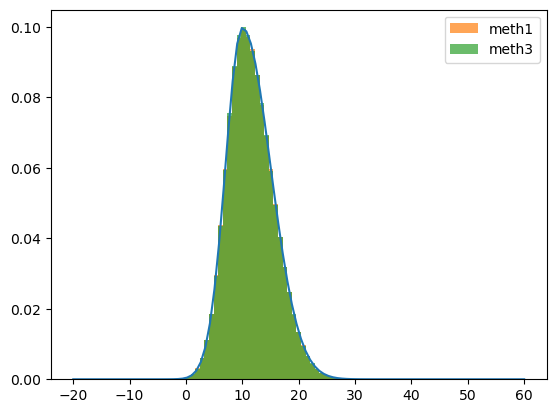

In [93]:
plt.plot(x, p_x)
plt.hist(x1, bins=np.linspace(0,40,50), density=True, alpha=0.7, label='meth1')
# plt.hist(x2, bins=np.linspace(0,40,50), density=True, alpha=0.7, label='meth2')
plt.hist(x3, bins=np.linspace(0,40,50), density=True, alpha=0.7, label='meth3')
plt.legend()
plt.show()